<a href="https://colab.research.google.com/github/simulate111/Computer-Vision-and-Sensor-Fusion/blob/main/assignment_2_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Add libraries

In [ ]:
import tensorflow as tf
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50
import os
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import zipfile
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Path system

In [ ]:
# you need the current working directory NB: works both windows and linux
current_working_directory = os.getcwd()
current_working_directory = os.path.dirname(current_working_directory)

# get the directory where I want to download the dataset
path_of_download = os.path.join(*['..', current_working_directory, 'Datasets', 'weather_dataset'])
print(f"[DIR] The directory of the current dataset is {path_of_download}")

[DIR] The directory of the current dataset is /Datasets/weather_dataset


### function for data loading

In [ ]:
# here let s do some functions that we can re-use also for other assignment
def load_the_data_and_the_labels(data_set_path: str, target_size: tuple or None = None):
    try:
        dataset, labels, name_of_the_labels = list(), list(), list()
        # let s loop here and we try to discover how many class we have
        for class_number, class_name in enumerate(os.listdir(data_set_path)):
            full_path_the_data = os.path.join(data_set_path, class_name)
            print(f"[WALK] I am walking into {full_path_the_data}")

            # add the list to nam _list
            name_of_the_labels.append(class_name)

            for single_image in os.listdir(f"{full_path_the_data}"):
                full_path_to_image = os.path.join(*[full_path_the_data, single_image])

                # add the class number
                labels.append(class_number)

                if target_size is None:
                    # let s load the image
                    image = tf.keras.utils.load_img(full_path_to_image)
                else:
                    image = tf.keras.utils.load_img(full_path_to_image, target_size=target_size)

                # transform PIL object in image
                image = tf.keras.utils.img_to_array(image)

                # add the image to the ds list
                dataset.append(image)

        return np.array(dataset, dtype='uint8'), np.array(labels, dtype='int'), name_of_the_labels
    except Exception as ex:
        print(f"[EXCEPTION] load the data and the labels throws exceptions {ex}")

### OHE function

In [ ]:
# here we have to one hot encode the labes
def make_the_one_hot_encoding(labels_to_transform):
    try:
        enc = OneHotEncoder(handle_unknown='ignore')
        # this is a trick to figure the array as 2d array instead of list
        temp = np.reshape(labels_to_transform, (-1, 1))
        labels_to_transform = enc.fit_transform(temp).toarray()
        print(f'[ONE HOT ENCODING] Labels are one-hot-encoded: {(labels_to_transform.sum(axis=1) - np.ones(labels_to_transform.shape[0])).sum() == 0}')
        return labels_to_transform
    except Exception as ex:
        print(f"[EXCEPTION] Make the one hot encoding throws exception {ex}")

### load the data and labels

In [ ]:
from google.colab import files
#uploaded = files.upload()

In [ ]:
url = "https://seafile.utu.fi/f/88c08f841e0348e1a412/?dl=1"
zip_path = "/content/weather_dataset.zip"
urllib.request.urlretrieve(url, zip_path)

('/content/weather_dataset.zip', <http.client.HTTPMessage at 0x7a3b0f3b2f10>)

In [ ]:
extract_path = "/content/weather_dataset"
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
dataset, labels, class_names = load_the_data_and_the_labels("/content/weather_dataset/weather_dataset", target_size=(224, 224))

[WALK] I am walking into /content/weather_dataset/weather_dataset/Sunrise
[WALK] I am walking into /content/weather_dataset/weather_dataset/Rain
[WALK] I am walking into /content/weather_dataset/weather_dataset/Shine
[WALK] I am walking into /content/weather_dataset/weather_dataset/Cloudy


### normalize the data

In [ ]:
# Normalize images
dataset = dataset / 255.0

In [ ]:
encoded_labels = make_the_one_hot_encoding(labels)

[ONE HOT ENCODING] Labels are one-hot-encoded: True


### split the dataset in train and test set (ratio 0.3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dataset, encoded_labels, test_size=0.3, stratify=labels)

In [ ]:
# Set up data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit data augmentation on training data
datagen.fit(X_train)

### create the CNN and set all parameters to trainable
a.	Input layer
b.	As base model use VGG19:
    i.	Weights: imagenet
    ii.	Include_top: False
    iii.	Input_shape the target shape described in point 1.
c.	Add a flatten layer
d.	Add a Dense layer with 512 units and a dropout layer with 0.1 unit.
e.	Add a Dense layer with 256 units and a dropout layer with 0.1 unit.
f.	Add the final classifier with the correct number of units and the suitable activation.


In [ ]:
def cnn_ResNet50(input_shape=(224, 224, 3), num_classes=4):
    #a
    input_layer = Input(shape=input_shape)
    #b
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer)
    base_model.trainable = True
    #c
    flatten_layer = Flatten()(base_model.output)
    #d
    dense = Dense(512, activation='relu', kernel_regularizer=l2(0.04))(flatten_layer)
    dropout = Dropout(0.7)(dense)
    #e
    dense2 = Dense(256, activation='relu', kernel_regularizer=l2(0.04))(dropout)
    dropout2 = Dropout(0.7)(dense2)
    #f
    output_layer = Dense(num_classes, activation='softmax')(dropout2)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [ ]:
model = cnn_ResNet50()
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 75,100,804 (286.49 MB)

 Trainable params: 75,047,684 (286.28 MB)

 Non-trainable params: 53,120 (207.50 KB)

### compile the model with adam

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

### Fit the model with batch size 32 and 15 epochs (This take 15 - 20 minutes with the CPU)

In [ ]:
#Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
model.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=(X_test, y_test), epochs=15, callbacks=[early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.2442 - loss: 59.6539 - val_accuracy: 0.2781 - val_loss: 55.4813
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 517ms/step - accuracy: 0.3738 - loss: 57.7777 - val_accuracy: 0.2781 - val_loss: 55.4283
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 535ms/step - accuracy: 0.3848 - loss: 57.0882 - val_accuracy: 0.3107 - val_loss: 55.3243
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 539ms/step - accuracy: 0.4681 - loss: 56.1944 - val_accuracy: 0.3225 - val_loss: 55.1954
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 554ms/step - accuracy: 0.4858 - loss: 55.6572 - val_accuracy: 0.3166 - val_loss: 55.0678
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 547ms/step - accuracy: 0.5303 - loss: 55.1785 - val_accuracy: 0.3195 - val_loss: 54.9626
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 536ms/step - accuracy: 0.5205 - loss: 55.0027 - val_accuracy: 0.2929 - val_loss: 54.8307
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 550ms/step - accuracy: 0.6017 - loss: 54.69

### Evaluate  the model

In [ ]:
model.evaluate(X_test, y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.2580 - loss: 53.8665


[53.875518798828125, 0.24852071702480316]

#### Make and show predictions

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 557ms/step


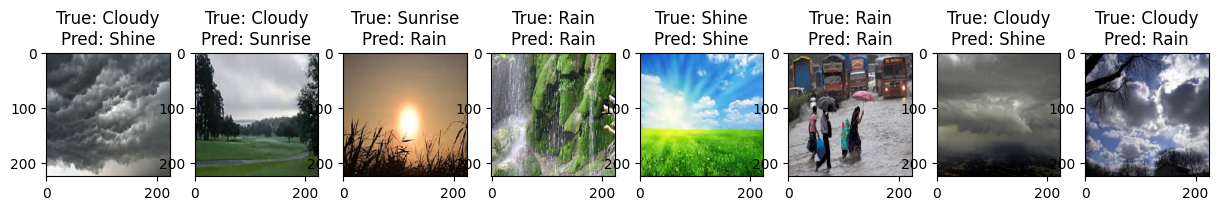

In [ ]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
def plot_predictions(images, true_labels, predicted_labels, class_names, num_images=8):
    plt.figure(figsize=(15, 7))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        true_label = class_names[true_labels[i]]
        predicted_label = class_names[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
plot_predictions(X_test, true_classes, predicted_classes, class_names)

### make confusion matrix

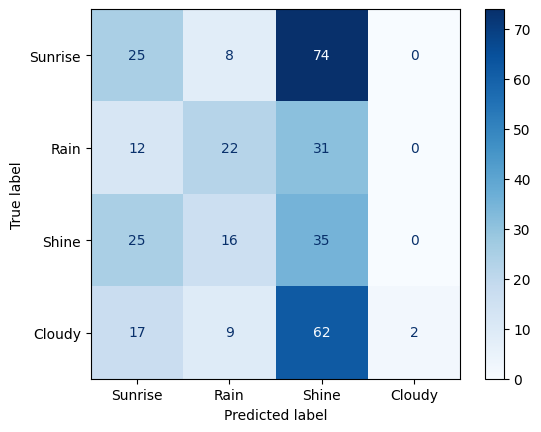

In [ ]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

### Load again the cnn but this time set the parameters to NOT TRAINABLE

In [ ]:
def cnn_ResNet50_non_trainable(input_shape=(224, 224, 3), num_classes=4):
    input_layer = Input(shape=input_shape)
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer)
    base_model.trainable = False
    flatten_layer = Flatten()(base_model.output)
    dense = Dense(512, activation='relu', kernel_regularizer=l2(0.04))(flatten_layer)
    dropout = Dropout(0.7)(dense)
    dense2 = Dense(256, activation='relu', kernel_regularizer=l2(0.04))(dropout)
    dropout2 = Dropout(0.7)(dense2)
    output_layer = Dense(num_classes, activation='softmax')(dropout2)
    model = Model(inputs=input_layer, outputs=output_layer)
    return model

### Fit the model with batch size 32 and 15 epochs (This is fsaster)

In [ ]:
model2 = cnn_ResNet50_non_trainable()
model2.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
model2.fit(datagen.flow(X_train, y_train, batch_size=32), validation_data=(X_test, y_test), epochs=15, callbacks=[early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.2432 - loss: 56.1170 - val_accuracy: 0.2604 - val_loss: 52.0068
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 450ms/step - accuracy: 0.2555 - loss: 51.4636 - val_accuracy: 0.3166 - val_loss: 48.5218
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 445ms/step - accuracy: 0.2767 - loss: 47.8435 - val_accuracy: 0.3254 - val_loss: 45.3395
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 410ms/step - accuracy: 0.2924 - loss: 44.6477 - val_accuracy: 0.3136 - val_loss: 42.4426
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 455ms/step - accuracy: 0.3069 - loss: 41.8082 - val_accuracy: 0.3225 - val_loss: 39.7877
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 440ms/step - accuracy: 0.2831 - loss: 39.2031 - val_accuracy: 0.3314 - val_loss: 37.3614
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 472ms/step - accuracy: 0.2949 - loss: 36.8144 - val_accuracy: 0.3314 - val_loss: 35.1473
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 454ms/step - accuracy: 0.2914 - loss: 34.660

# Evaluate the model

In [ ]:
test_loss, test_accuracy = model2.evaluate(X_test, y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.3682 - loss: 23.0392


### Make and show some predictions

11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 437ms/step


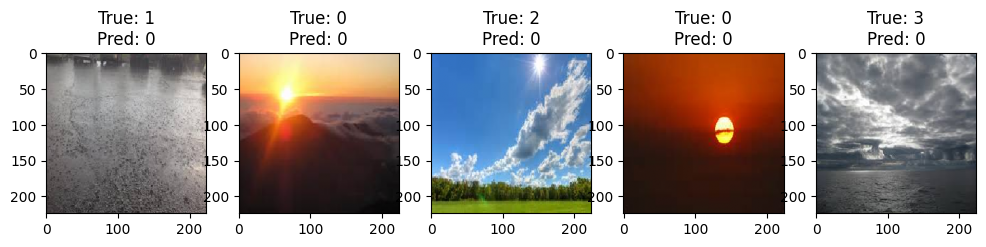

In [ ]:
y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
num_samples = 5
random_indices = np.random.choice(len(X_test), num_samples, replace=False)
plt.figure(figsize=(12, 6))
for i, idx in enumerate(random_indices):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(X_test[idx])
    true_label = y_true_classes[idx]
    pred_label = y_pred_classes[idx]
    plt.title(f"True: {true_label}\nPred: {pred_label}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step


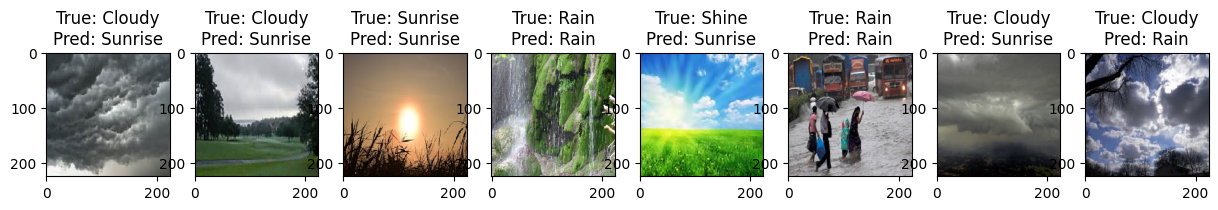

In [ ]:
predictions = model2.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
def plot_predictions(images, true_labels, predicted_labels, class_names, num_images=8):
    plt.figure(figsize=(15, 7))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        true_label = class_names[true_labels[i]]
        predicted_label = class_names[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
plot_predictions(X_test, true_classes, predicted_classes, class_names)

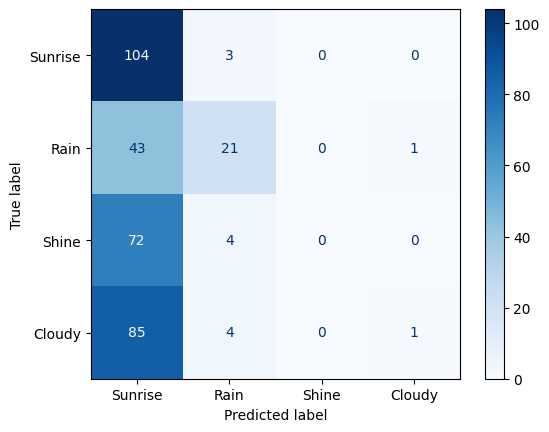

In [ ]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

In [ ]:
from sklearn.model_selection import KFold
#K-fold cross-validation
kf = KFold(n_splits=4, shuffle=True)
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=7)

Epoch 1/7
19/19 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.7814 - loss: 52.8707 - val_accuracy: 0.3046 - val_loss: 53.6571
Epoch 2/7
19/19 ━━━━━━━━━━━━━━━━━━━━ 29s 310ms/step - accuracy: 0.7745 - loss: 52.7348 - val_accuracy: 0.3096 - val_loss: 53.5316
Epoch 3/7
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 307ms/step - accuracy: 0.7396 - loss: 52.5797 - val_accuracy: 0.2944 - val_loss: 53.3537
Epoch 4/7
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 310ms/step - accuracy: 0.7775 - loss: 52.4498 - val_accuracy: 0.3553 - val_loss: 53.1850
Epoch 5/7
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 315ms/step - accuracy: 0.7856 - loss: 52.3289 - val_accuracy: 0.3503 - val_loss: 53.0014
Epoch 6/7
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 311ms/step - accuracy: 0.8030 - loss: 52.1037 - val_accuracy: 0.3858 - val_loss: 52.9045
Epoch 7/7
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 317ms/step - accuracy: 0.8367 - loss: 51.8863 - val_accuracy: 0.3807 - val_loss: 52.7760
Epoch 1/7
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 328ms/step - accuracy: 0.8301 - loss: 51.8581 - val_accu

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9256 - loss: 48.4742


In [ ]:
from sklearn.model_selection import KFold
#K-fold cross-validation
kf = KFold(n_splits=4, shuffle=True)
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    model2.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=7)

Epoch 1/7
19/19 ━━━━━━━━━━━━━━━━━━━━ 19s 460ms/step - accuracy: 0.2876 - loss: 22.8461 - val_accuracy: 0.3452 - val_loss: 22.2751
Epoch 2/7
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.2545 - loss: 22.1215 - val_accuracy: 0.3756 - val_loss: 21.5754
Epoch 3/7
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.3131 - loss: 21.4109 - val_accuracy: 0.3299 - val_loss: 20.9143
Epoch 4/7
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 0.2886 - loss: 20.7624 - val_accuracy: 0.3604 - val_loss: 20.2966
Epoch 5/7
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.2800 - loss: 20.1582 - val_accuracy: 0.3604 - val_loss: 19.7229
Epoch 6/7
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.2700 - loss: 19.5858 - val_accuracy: 0.3503 - val_loss: 19.1874
Epoch 7/7
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.2932 - loss: 19.0816 - val_accuracy: 0.3909 - val_loss: 18.6883
Epoch 1/7
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.3036 - loss: 18.5750 - val_accu

In [ ]:
test_loss, test_accuracy = model2.evaluate(X_test, y_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.3750 - loss: 13.2463
